# <h1><center> Predictive Analysis - Web Traffic Time Series Forecasting | Kaggle

The goal of this notebook is not to do the best model for each Time series. It is just a comparison of few models when you have one Time Series. The presentation present a different approaches to forecast a Time Series. 

The plan of the notebook is:

    I. Importation & Data Cleaning
    II. Aggregation & Visualisation
    III. Machine Learning Approach
    IV Basic Model Approach
    V. ARIMA approach (Autoregressive Integrated Moving Average)
    VI. (FB) Prophet Approach 
    VII. Keras Starter
    VIII. Comparaison & Conclusion


#  <h1><center> I. Importation & Data Cleaning

In this first part we will choose the Time Series to work in the others parts. The idea is to find a Time Serie who could be interesting to work with. So in the data we can find 145K Time Series. We will Find a good Time Series to introduce four approaches! So the first step is to import few libraries and the data. The four approaches are Basic Approach / ML Approach / GAM Approach / ARIMA Approach.

In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import re
%matplotlib inline
from zipfile import ZipFile

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat # 创建2D滞后数组
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go



plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
myzip=ZipFile('../input/web-traffic-time-series-forecasting/train_1.csv.zip')
f=myzip.open('train_1.csv')

In [3]:
train = pd.read_csv(f).fillna(0)

f.close()
myzip.close()

In [4]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
# Load the data
# train = pd.read_csv("../input/train_1.csv")

In [6]:
# 压缩训练数据，选择后50列的数据进行转换
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')

train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float) # 能够整除5，就是 周六 + 周日,(休息日)
# train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) == 6 | 0 ).astype(float) # 筛选出 周六 和 周日

In [7]:
train_flattened.date.dt.dayofweek.unique()

array([5, 6, 0, 1, 2, 3, 4])

In [8]:
train_flattened.head()

,Page,date,Visits,weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-12,38.0,1.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-12,13.0,1.0


In [9]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [10]:
train_flattened.reset_index(drop=False,inplace=True)

In [11]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

In [12]:
train_flattened['weekday'].unique()

array([5, 6, 0, 1, 2, 3, 4])

In [13]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.78,2.0,5
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.78,2.0,6
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.78,2.0,0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.78,2.0,1
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.78,2.0,2


In [14]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [15]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.78,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.78,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.78,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.78,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.78,2.0,2,2016,11,16


This part allowed us to prepare our data. We had created new features that we use in the next steps. Days, Months, Years are interesting to forecast with a Machine Learning Approach or to do an analysis. 
If you have another idea to improve this first part: Fork this notebook and improve it or share your idea in the comments.

# <h1><center>II. Aggregation & Visualisation

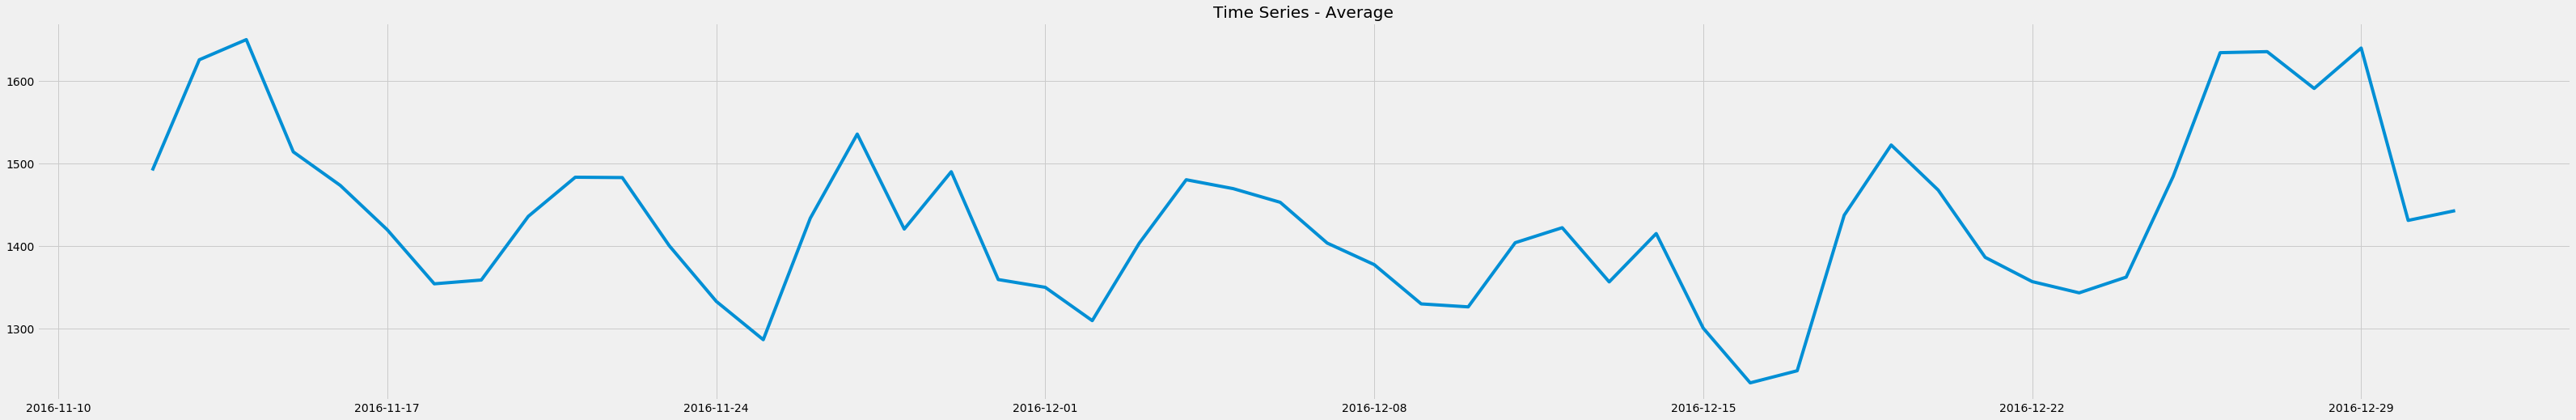

In [16]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

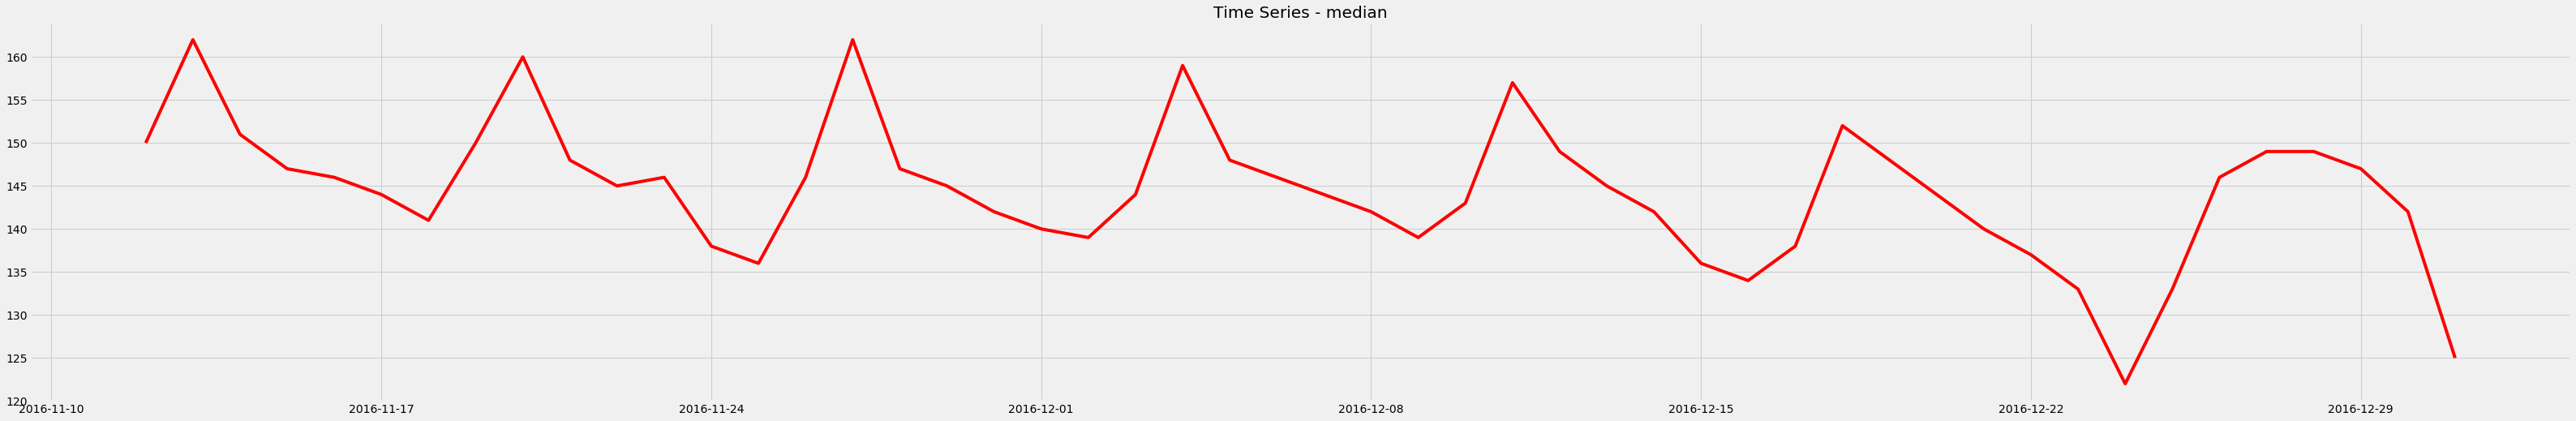

In [17]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

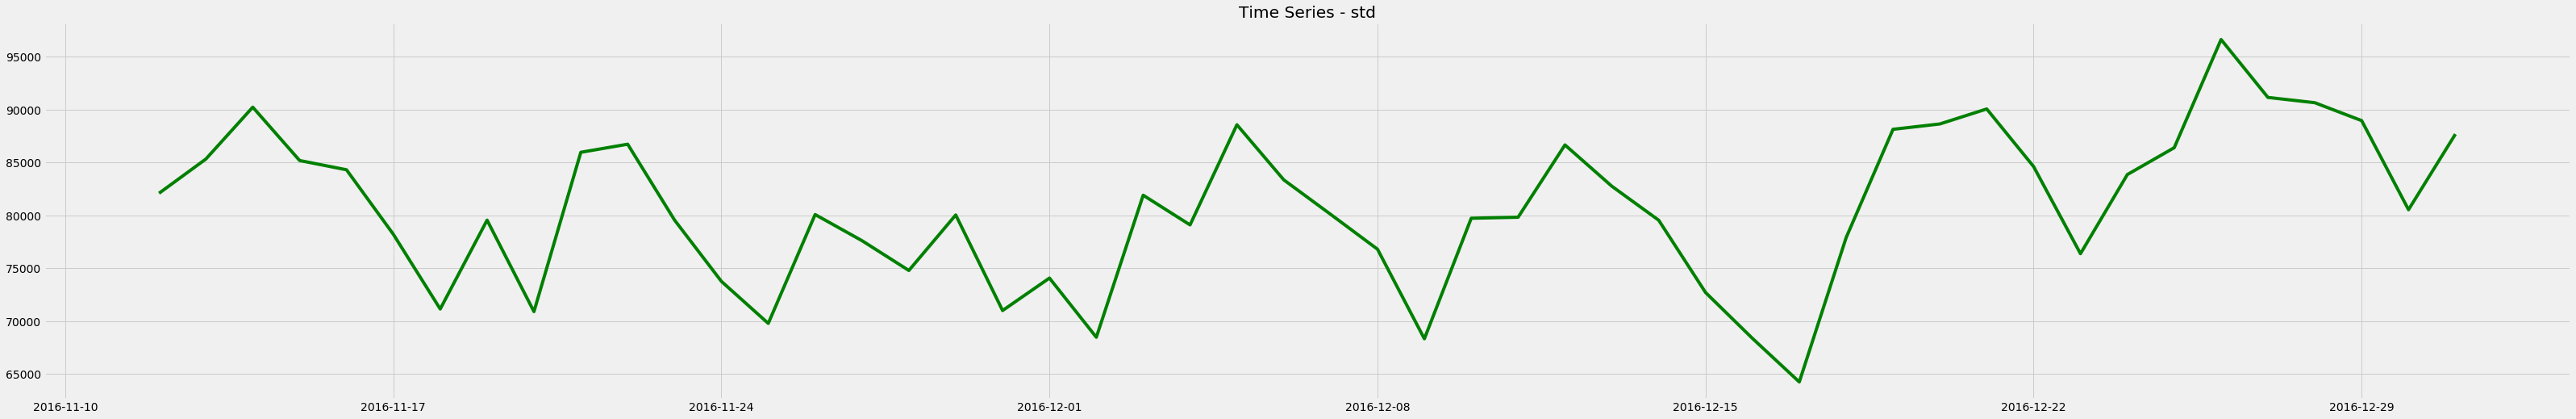

In [18]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [19]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [20]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day,month_num,weekday_num
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.78,2.0,06 - Saturday,2016,11,12,11,5
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.78,2.0,07 - Sunday,2016,11,13,11,6
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.78,2.0,01 - Monday,2016,11,14,11,0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.78,2.0,02 - Tuesday,2016,11,15,11,1
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.78,2.0,03 - Wednesday,2016,11,16,11,2


In [21]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

In [22]:
train_group

month,11,12
weekday,,
01 - Monday,1518.048230,1512.160439
02 - Tuesday,1495.761085,1478.275865
03 - Wednesday,1411.185310,1449.072529
04 - Thursday,1376.463395,1405.084617
05 - Friday,1320.550557,1329.783884
06 - Saturday,1428.114438,1356.912439
07 - Sunday,1532.457746,1451.596903


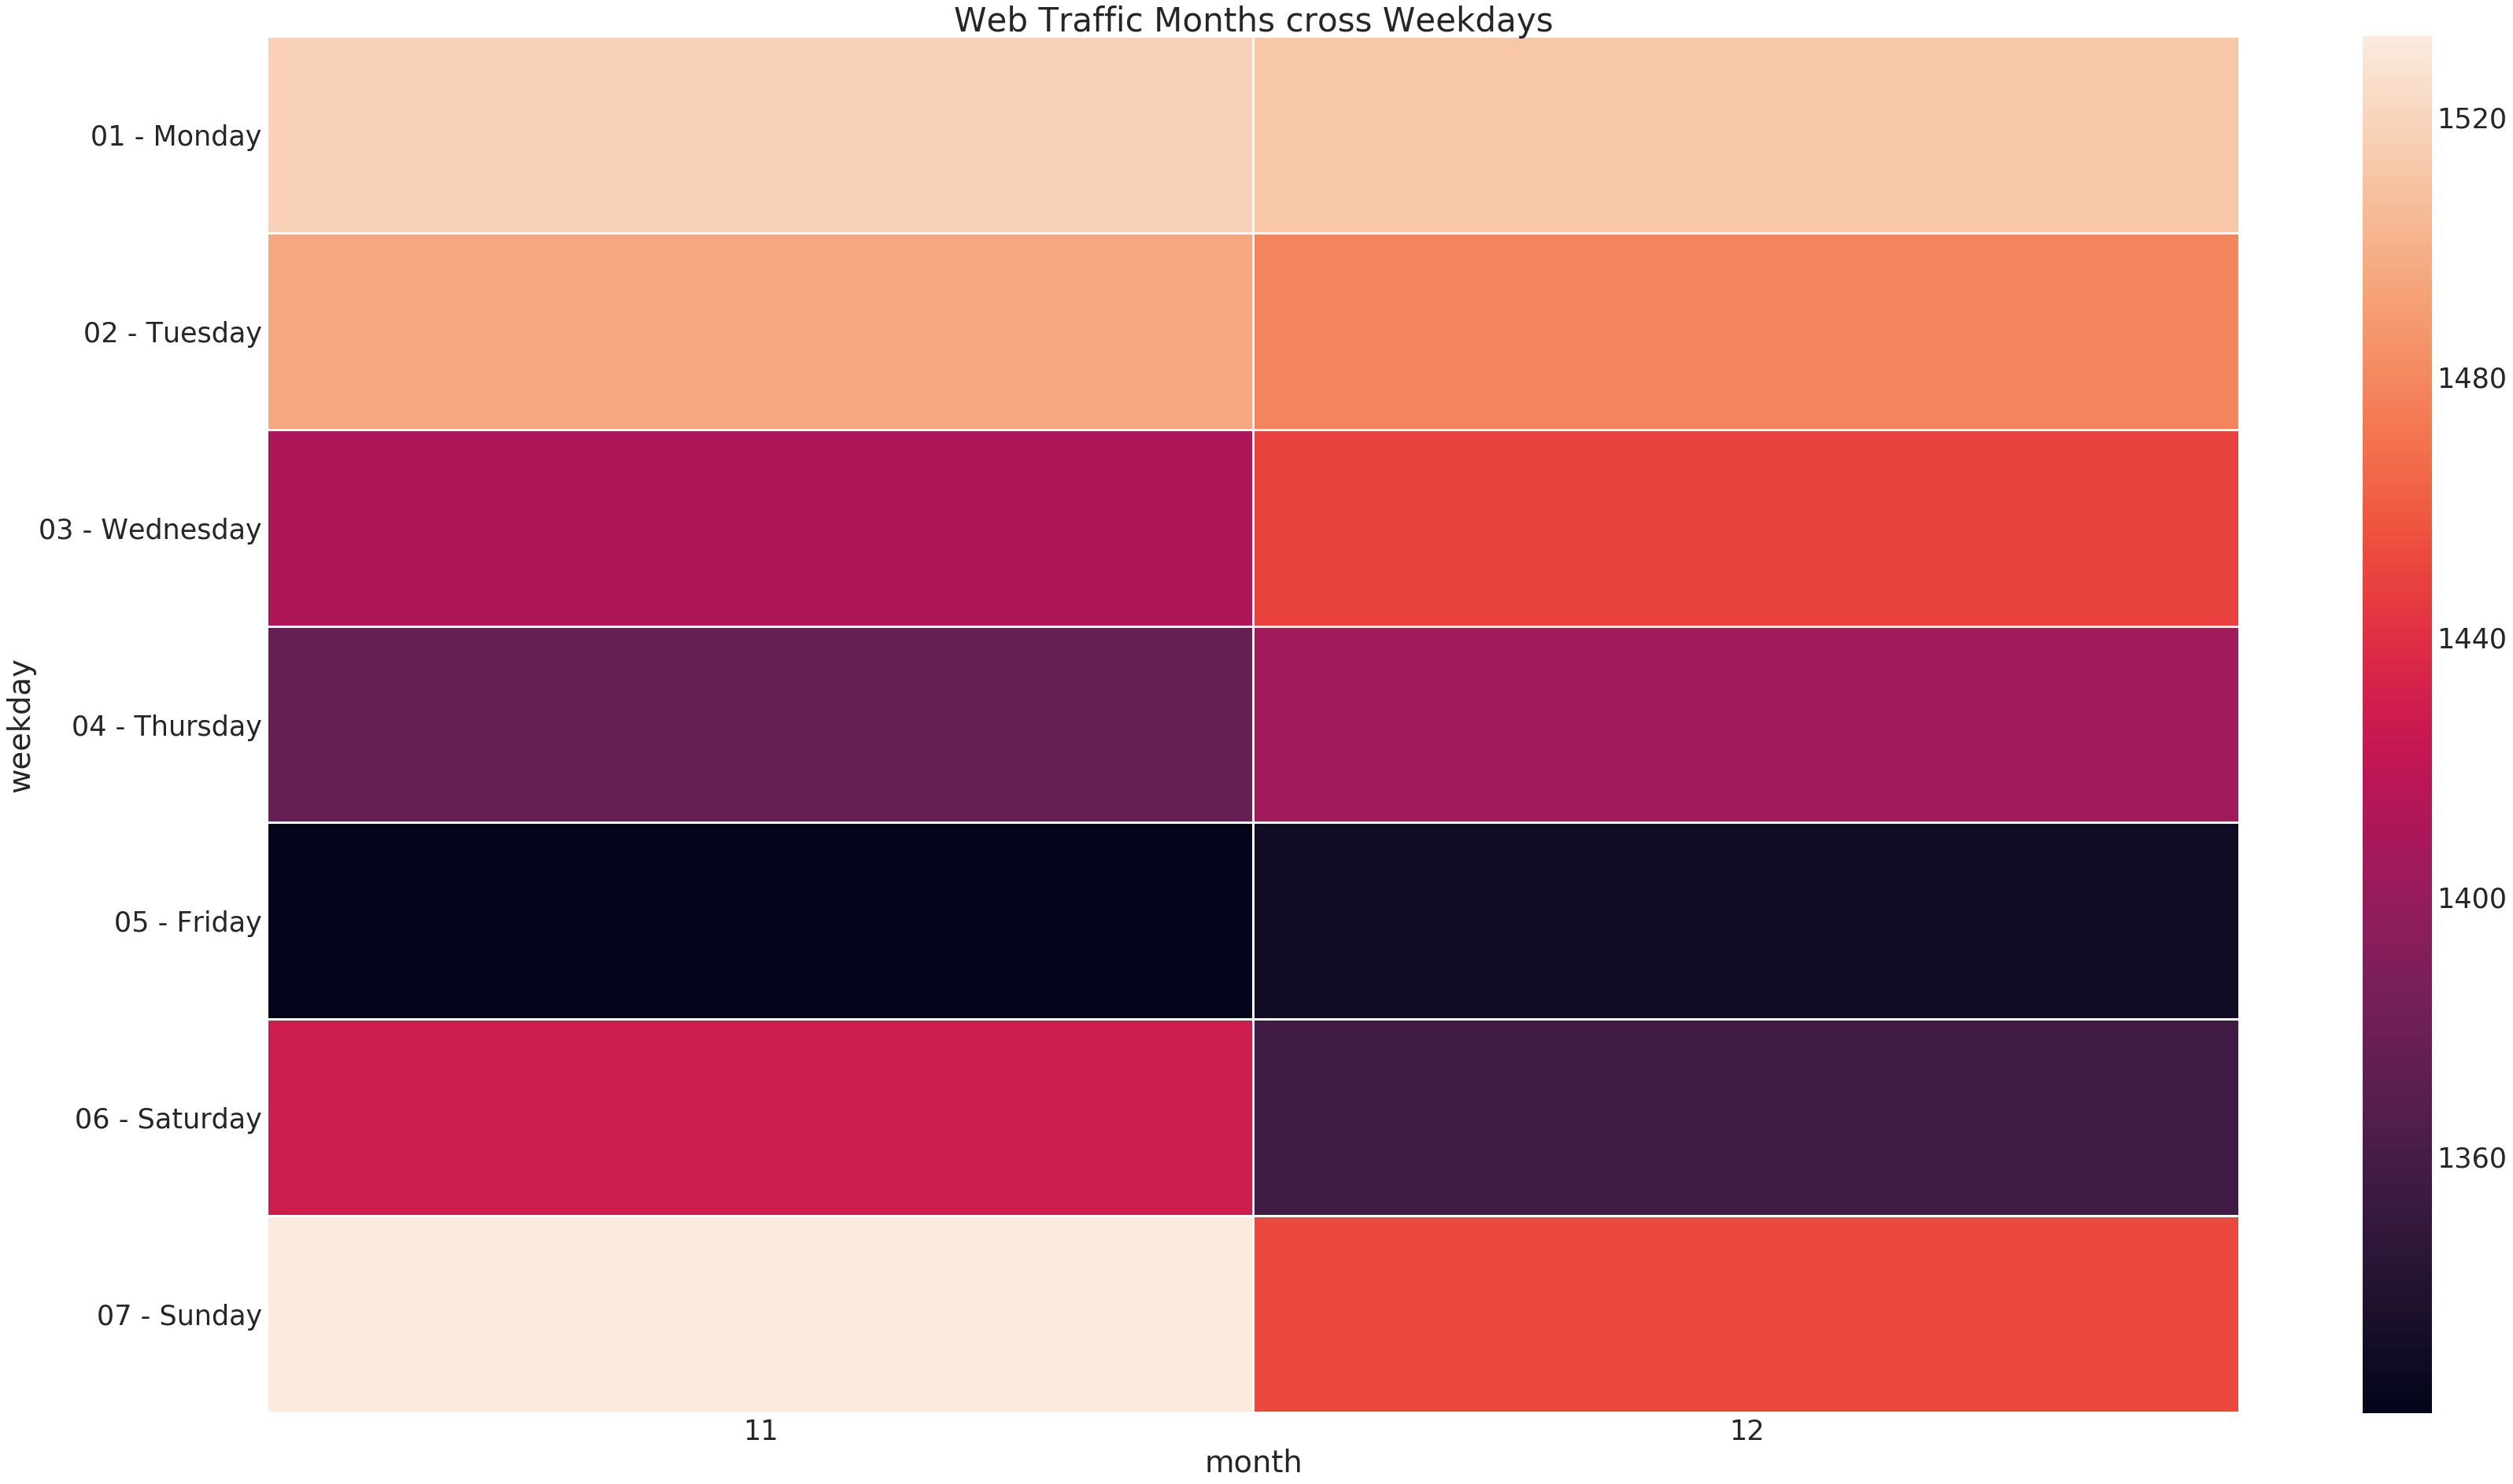

In [23]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

This heatmap show us in average the web traffic by weekdays cross the months. In our data we can see there are less activity in Friday and Saturday for December and November. And the biggest traffic is on the period Monday - Wednesday. It is possible to do Statistics Test to check if our intuition is ok. But You have a lot of works ! 

In [24]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

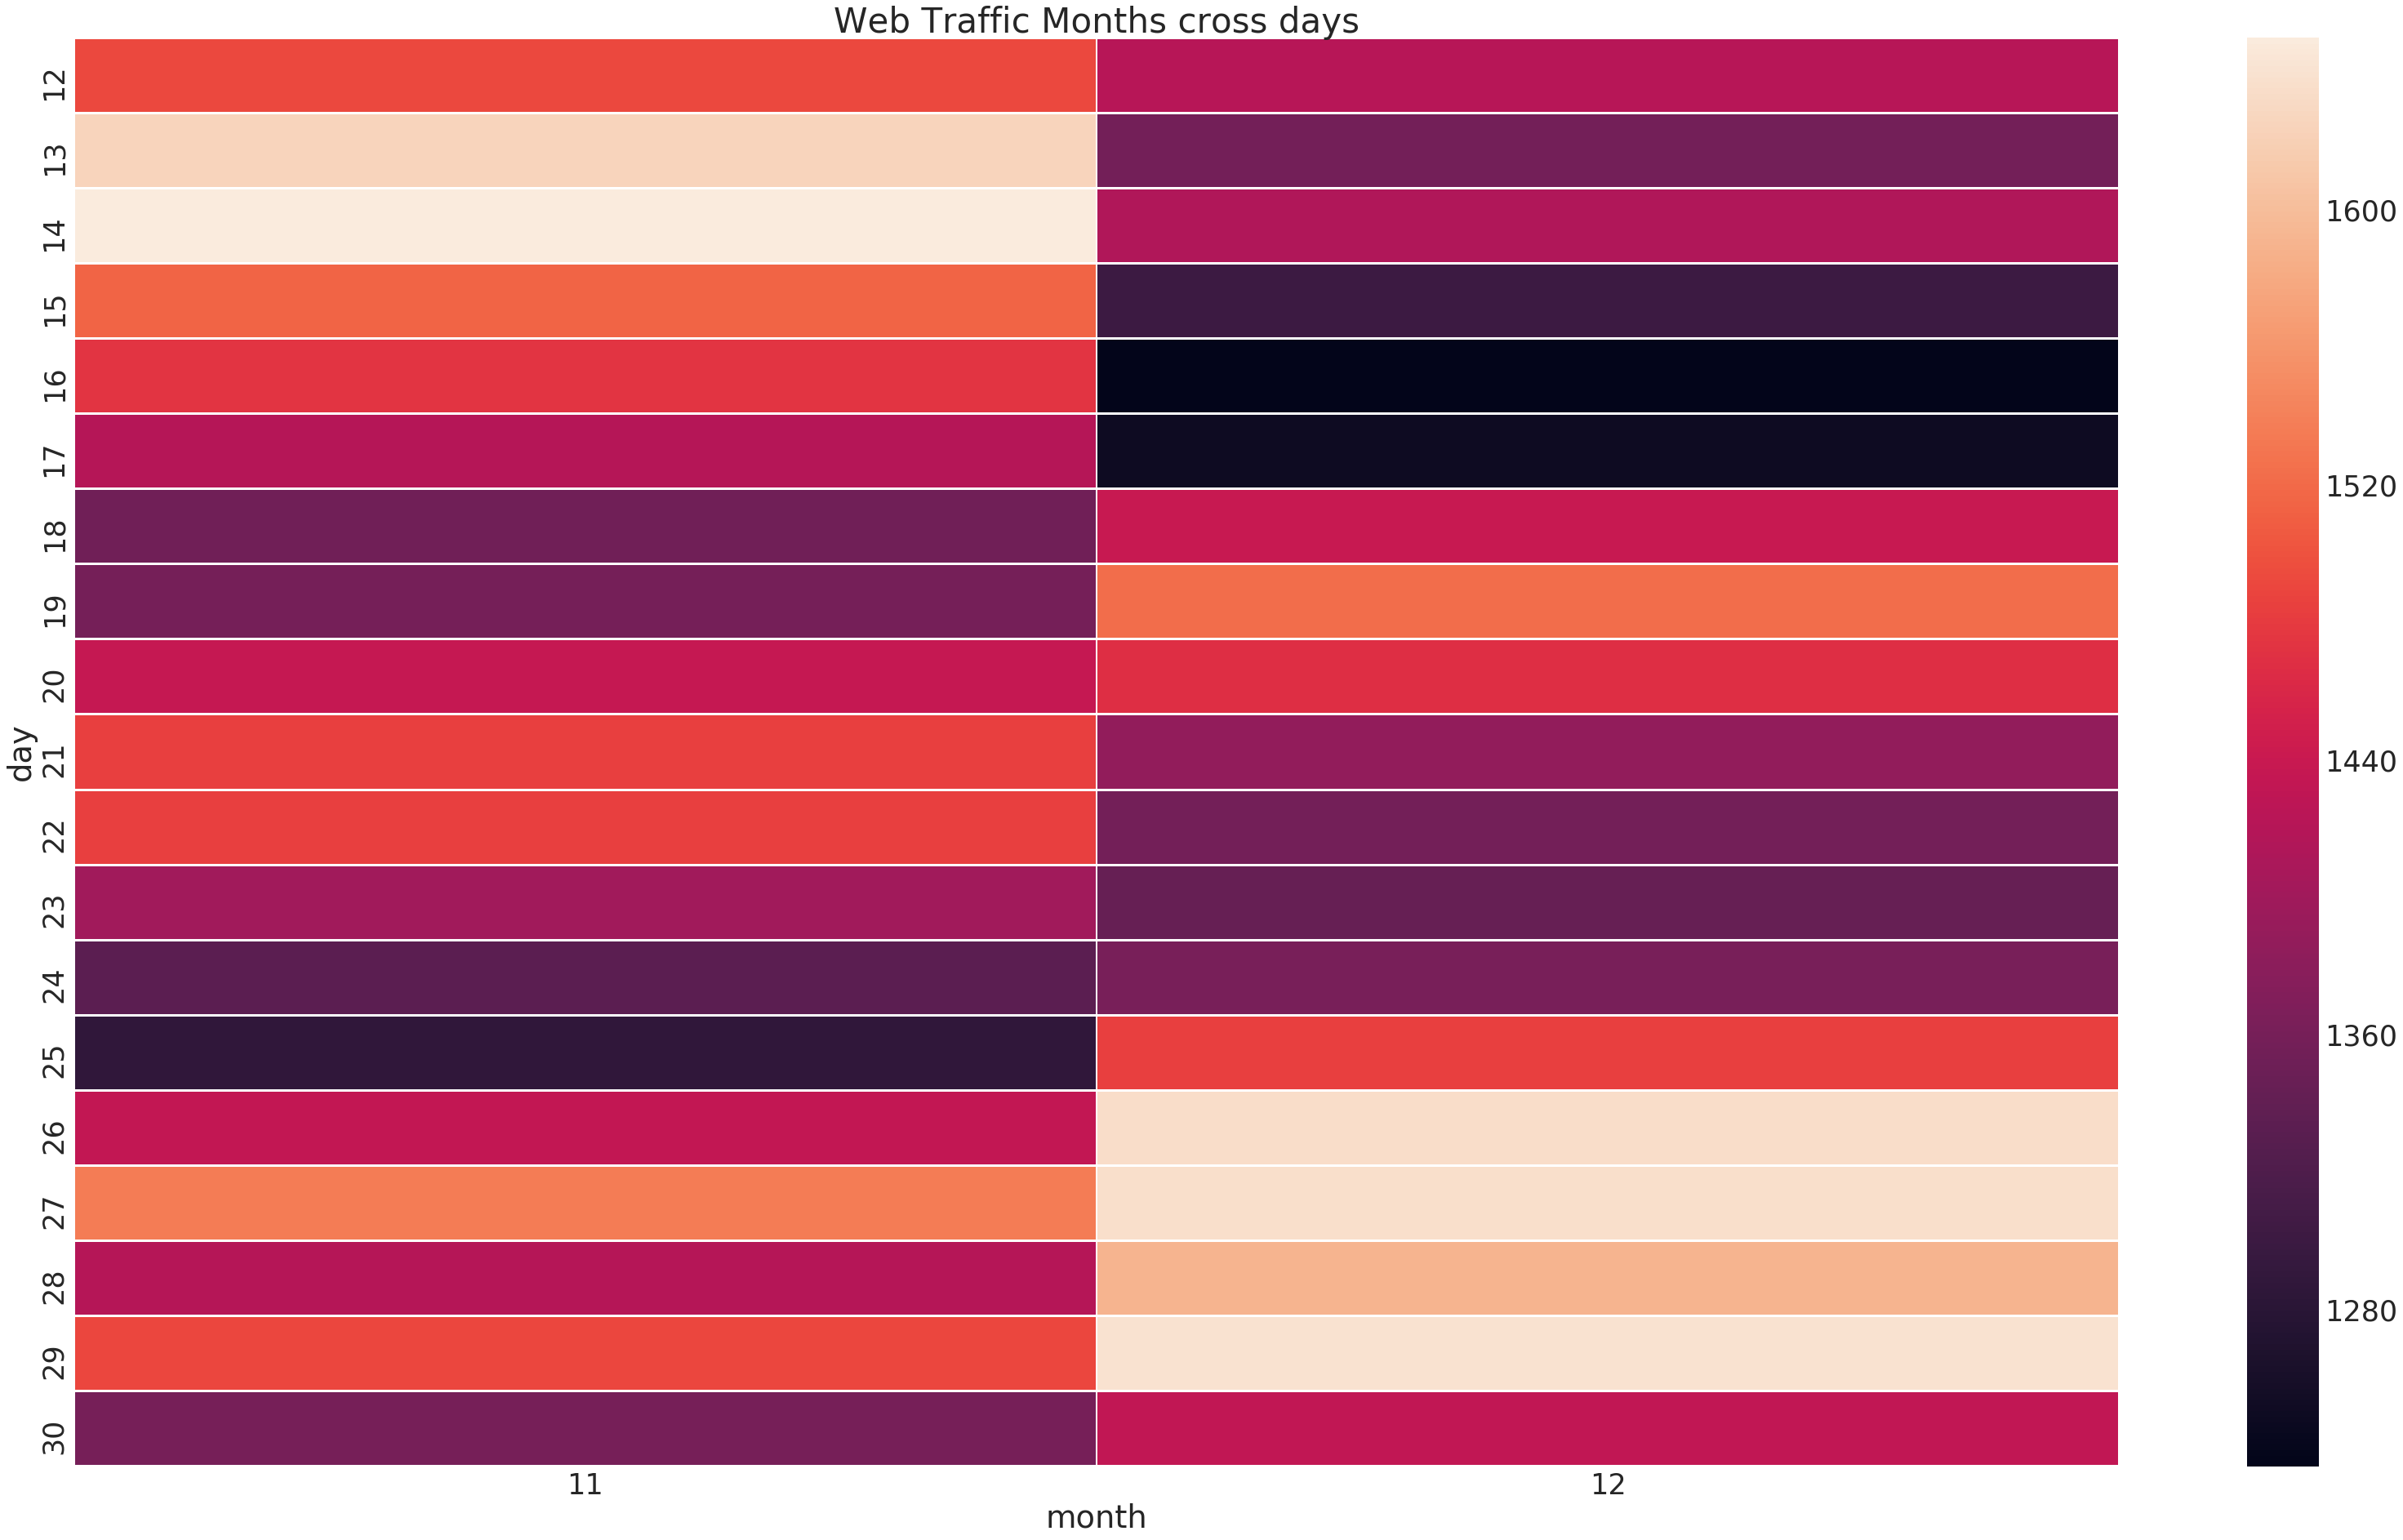

In [25]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

With this graph it is possible to see they are two periods with a bigger activity than the rest. The two periods are 25-29 December and 13-14 November. And we can see one period with little activity 15-17 December. They are maybe few outliers during these two periods. You must to investigate more. (coming soon...)

#  <h1><center> III. ML Approach


The first approach introduces is the Machine Learnin Approach. We will use just a AdaBoostRegressor but you can try with other models if you want to find the best model. I tried with a linear model as like Ridge but ADA model is better. I will be interesting to check if GB or XGB can bit ADA. It is possible to do a Neural Network approach too. But this approach will be done if the kagglers want more !!

In [26]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1

times_series_means.head()

,date,Visits,weekday,Date_str,year,month,day
0,2016-11-12,1491.626266,5,2016-11-12 00:00:00,2016,11,12
1,2016-11-13,1625.662602,6,2016-11-13 00:00:00,2016,11,13
2,2016-11-14,1650.061015,0,2016-11-14 00:00:00,2016,11,14
3,2016-11-15,1514.151238,1,2016-11-15 00:00:00,2016,11,15
4,2016-11-16,1473.522090,2,2016-11-16 00:00:00,2016,11,16


In [27]:
times_series_means.drop('Date_str',axis = 1, inplace =True)

The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).  

In [28]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

# 进行差分计算
def diff_creation(data):
    data["diff"] = np.nan
    #   data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    #   data.ix[1:, "diff"] = (data.iloc[1:, 1].values - data.iloc[:len(data)-1, 1].values
    data['diff'] = times_series_means['Visits'].diff() 

    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

In [29]:
lagged.shape

(50, 14)

In [30]:
lagged.head(10)

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1491.626266,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-11-13,1625.662602,6,2016,11,13,134.036336,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-11-14,1650.061015,0,2016,11,14,24.398413,134.036336,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-11-15,1514.151238,1,2016,11,15,-135.909777,24.398413,134.036336,NaN,0.000000,0.000000,0.000000,0.000000
4,2016-11-16,1473.522090,2,2016,11,16,-40.629147,-135.909777,24.398413,134.036336,NaN,0.000000,0.000000,0.000000
5,2016-11-17,1419.787816,3,2016,11,17,-53.734274,-40.629147,-135.909777,24.398413,134.036336,NaN,0.000000,0.000000
6,2016-11-18,1354.377202,4,2016,11,18,-65.410615,-53.734274,-40.629147,-135.909777,24.398413,134.036336,NaN,0.000000
7,2016-11-19,1358.959321,5,2016,11,19,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,24.398413,134.036336,NaN
8,2016-11-20,1436.024596,6,2016,11,20,77.065275,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,24.398413,134.036336
9,2016-11-21,1483.431330,0,2016,11,21,47.406734,77.065275,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,24.398413


In [31]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [32]:
x_train.head()

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,weekday,day
8,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,24.398413,134.036336,6,20
9,77.065275,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,24.398413,0,21
10,47.406734,77.065275,4.582119,-65.410615,-53.734274,-40.629147,-135.909777,1,22
11,-0.415874,47.406734,77.065275,4.582119,-65.410615,-53.734274,-40.629147,2,23
12,-82.512970,-0.415874,47.406734,77.065275,4.582119,-65.410615,-53.734274,3,24


In [33]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 72.62445219777501
-----------------------------------------------


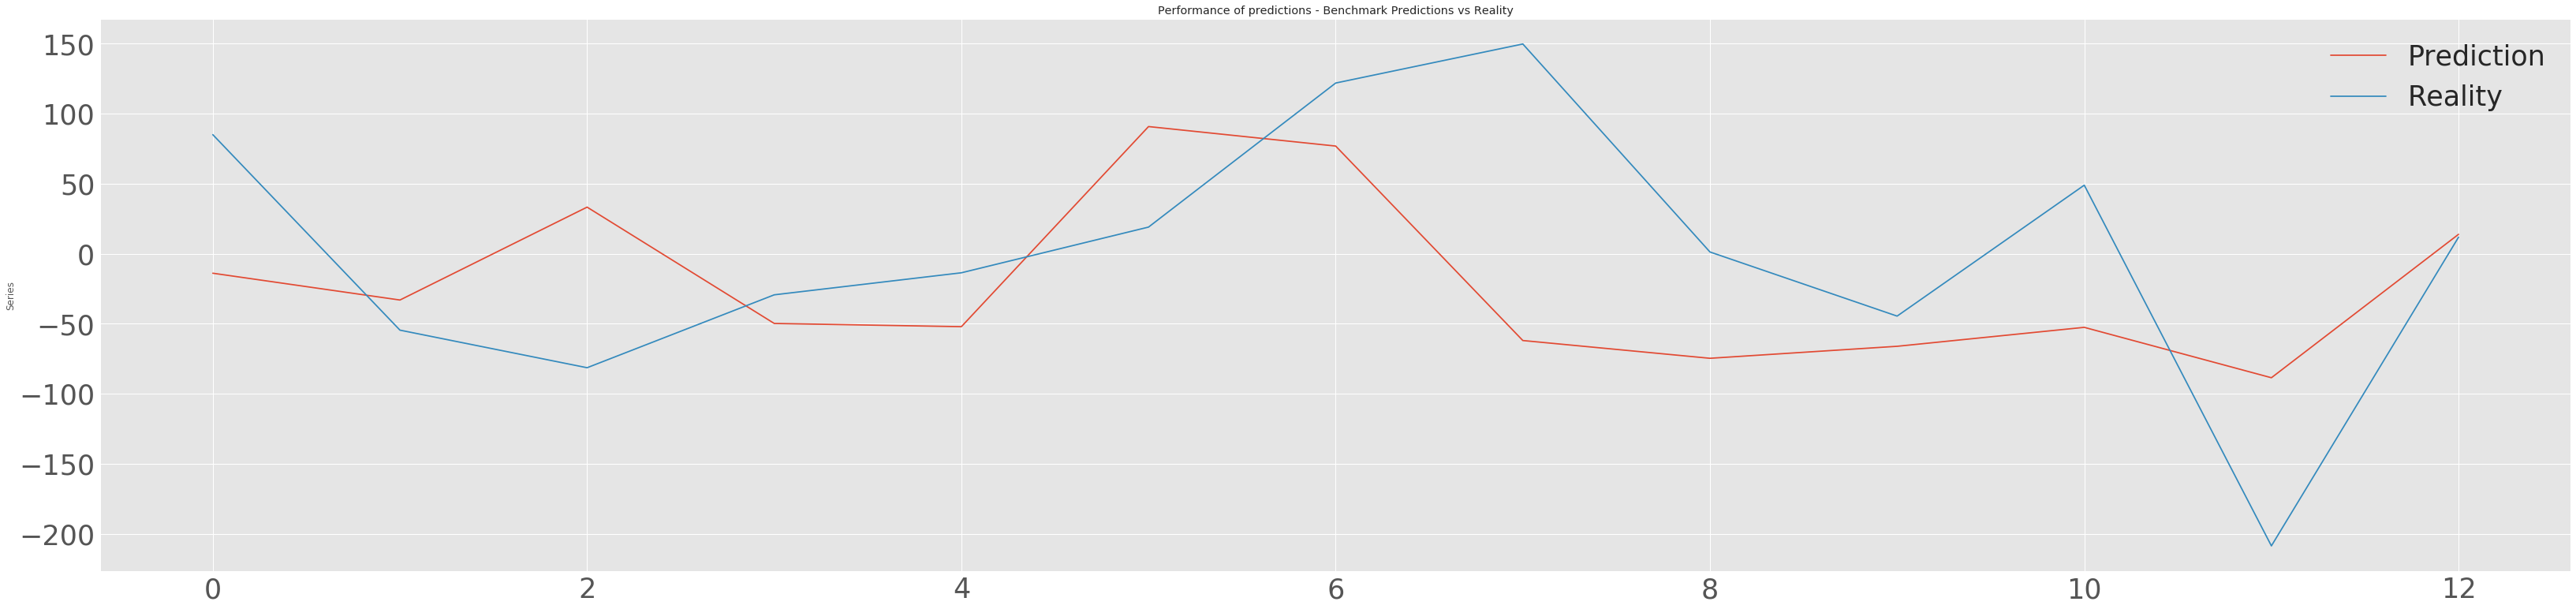

In [34]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [35]:
# Prediction 生成之后预测的一个时间序列 2017-01-01 ~ 2017-01-31
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"]) # Timestamp('2017-01-01 00:00:00')
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

In [36]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())   # 针对 data_pred 中的日期生成一个新特征 weekday 
        weekday = data_pred['weekday'][0]                                      
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])                                   # 新增一行数据，数据列和数据为 row 中定义的内容。
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff']) # 预测值

        # Loop 因为预测出的数据是差分数据，索引要加上该数据之前的一个 visits，形成一个真正的 visits
        if i == 0: 
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0] 

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)

    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [37]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

In [38]:
lagged.tail(32)

,Visits,date,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,month,weekday,year
47,1639.884526,2016-12-29,29,48.969296,-44.568036,1.241130,149.829143,121.939054,19.024982,-13.618152,-29.362449,NaN,12,3.0,2016
48,1431.159538,2016-12-30,30,-208.724988,48.969296,-44.568036,1.241130,149.829143,121.939054,19.024982,-13.618152,NaN,12,4.0,2016
49,1442.971633,2016-12-31,31,11.812095,-208.724988,48.969296,-44.568036,1.241130,149.829143,121.939054,19.024982,NaN,12,5.0,2016
50,1519.925367,2017-01-01,NaN,76.953734,11.812095,-208.724988,48.969296,-44.568036,1.241130,149.829143,121.939054,19.024982,NaN,6.0,NaN
51,1613.678688,2017-01-02,NaN,93.753321,76.953734,11.812095,-208.724988,48.969296,-44.568036,1.241130,149.829143,121.939054,NaN,0.0,NaN
52,1608.904345,2017-01-03,NaN,-4.774343,93.753321,76.953734,11.812095,-208.724988,48.969296,-44.568036,1.241130,149.829143,NaN,1.0,NaN
53,1563.981159,2017-01-04,NaN,-44.923186,-4.774343,93.753321,76.953734,11.812095,-208.724988,48.969296,-44.568036,1.241130,NaN,2.0,NaN
54,1543.564742,2017-01-05,NaN,-20.416417,-44.923186,-4.774343,93.753321,76.953734,11.812095,-208.724988,48.969296,-44.568036,NaN,3.0,NaN
55,1519.427966,2017-01-06,NaN,-24.136776,-20.416417,-44.923186,-4.774343,93.753321,76.953734,11.812095,-208.724988,48.969296,NaN,4.0,NaN
56,1531.799035,2017-01-07,NaN,12.371069,-24.136776,-20.416417,-44.923186,-4.774343,93.753321,76.953734,11.812095,-208.724988,NaN,5.0,NaN


In [39]:
lagged[lagged['diff']<0]
lagged.ix[(lagged.Visits < 0), 'Visits'] = 0 # 将访问量小于 0 的，设置为 0

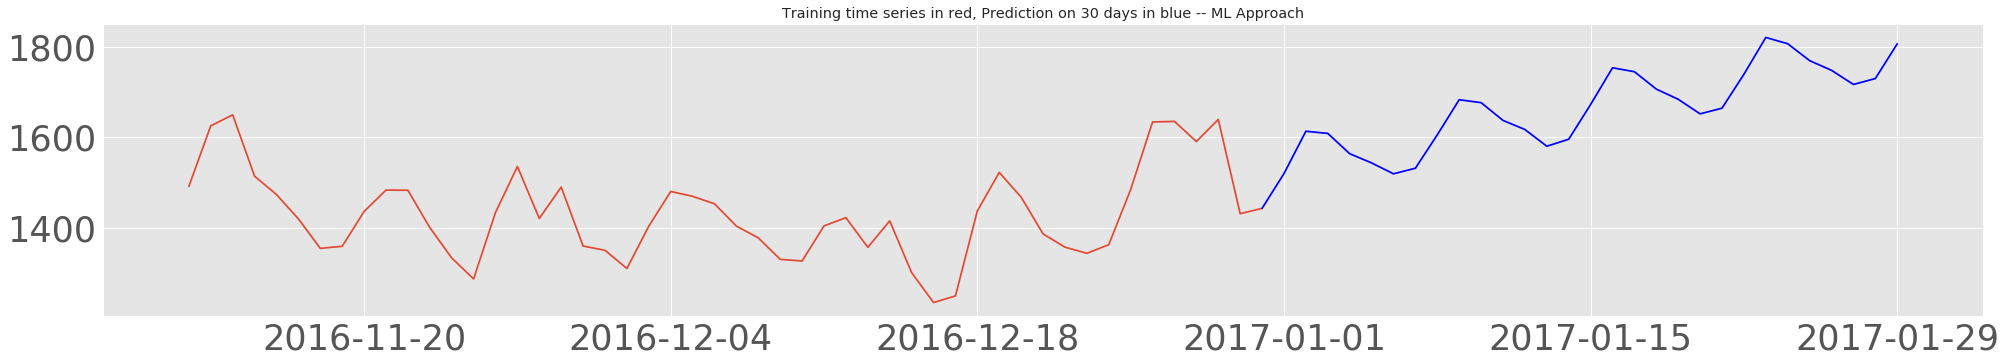

In [40]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

Finshed for the first approach ! The ML method requires a lot of work ! You need to create the features, the data to collect the prediction, optimisation etc... This method done a good results when there are a weekly pattern identified or a monthly pattern but we need more data.  

#  <h1><center> IV. Basic Approach

For this model We will use a simple model with the average of the activity by weekdays. In general rules the simplest things give good results !

对于这个模型，我们将使用一个简单的模型来计算工作日的活动平均值。一般来说，最简单的事情会带来好结果！

In [41]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]    # 保留 date、weekday、Visits 三列特征，作为训练数据
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]   # 筛选出时间大于 last_date 的数据
lagged_basic_pred.drop('Visits',inplace=True,axis=1)                  # 保留 date 和 weekday 两列特征

In [42]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())  # 计算每个 weekday 的浏览量
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

,weekday,Visits
0,0.0,1588.674580
1,1.0,1567.197432
2,2.0,1518.954885
3,3.0,1488.400445
4,4.0,1432.674641
5,5.0,1465.982336
6,6.0,1562.440619


In [43]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')   # merge 数据，按照 weekday 合并。使用每周的平均浏览量作为预测值
basic_approach = pd.concat([lagged_basic_tr,basic_pred])                   # concat 数据

In [44]:
basic_approach.tail()

,Visits,date,weekday
25,1488.400445,2017-01-26,3.0
26,1432.674641,2017-01-06,4.0
27,1432.674641,2017-01-13,4.0
28,1432.674641,2017-01-20,4.0
29,1432.674641,2017-01-27,4.0


In [45]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits) # 排序

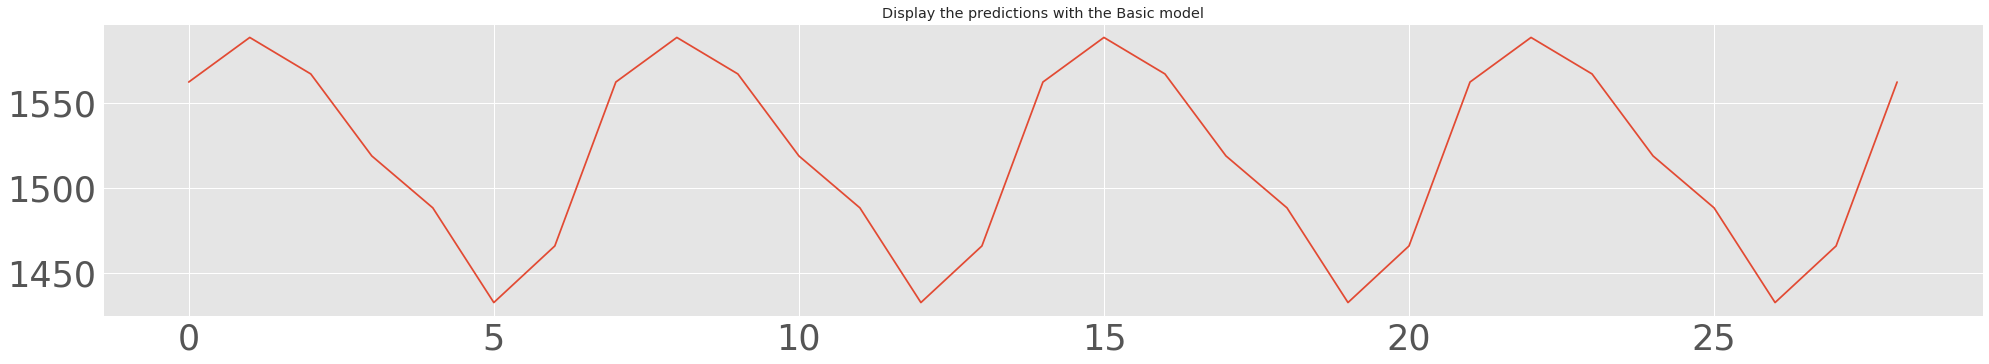

In [46]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

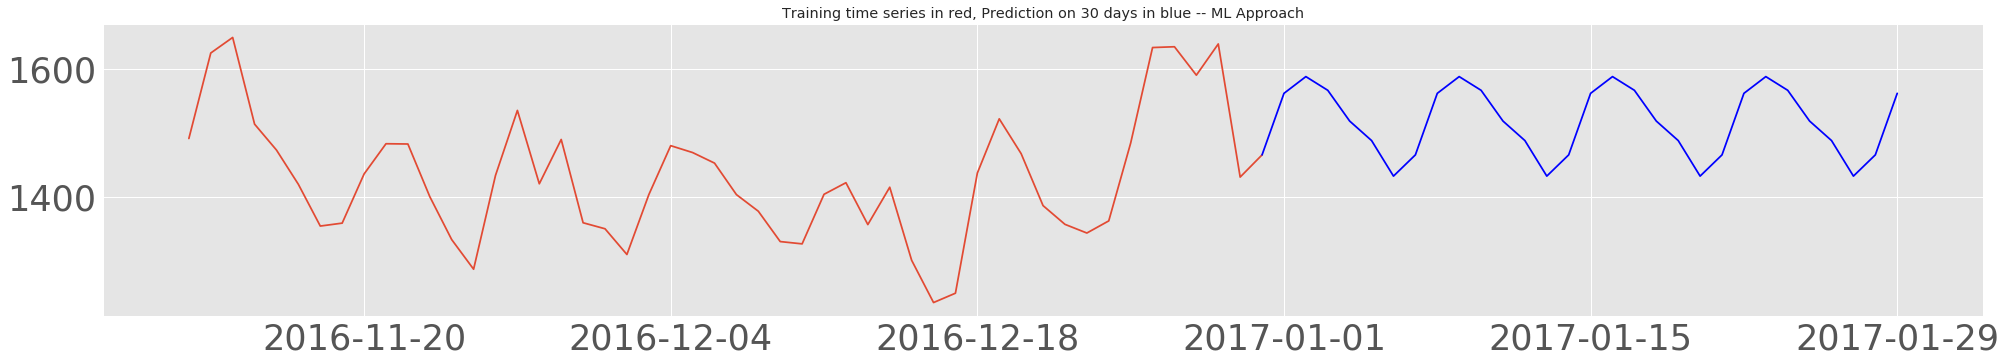

In [47]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

No optimisation ! No choice between linear, Bagging, boosting or others ! Just with an average by week days and we have a result ! Fast and easily !

没有优化！在线性、袋装、增压或其他方式之间别无选择！平均每周一天，我们就有结果了！又快又容易！

#  <h1><center>V. ARIMA

This part is inspired by: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
Very goodjob with the ARIMA models ! It is more simple when we have directly a stationary Time series. It is not our case...

We will use the Dickey-Fuller Test. More informations here: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

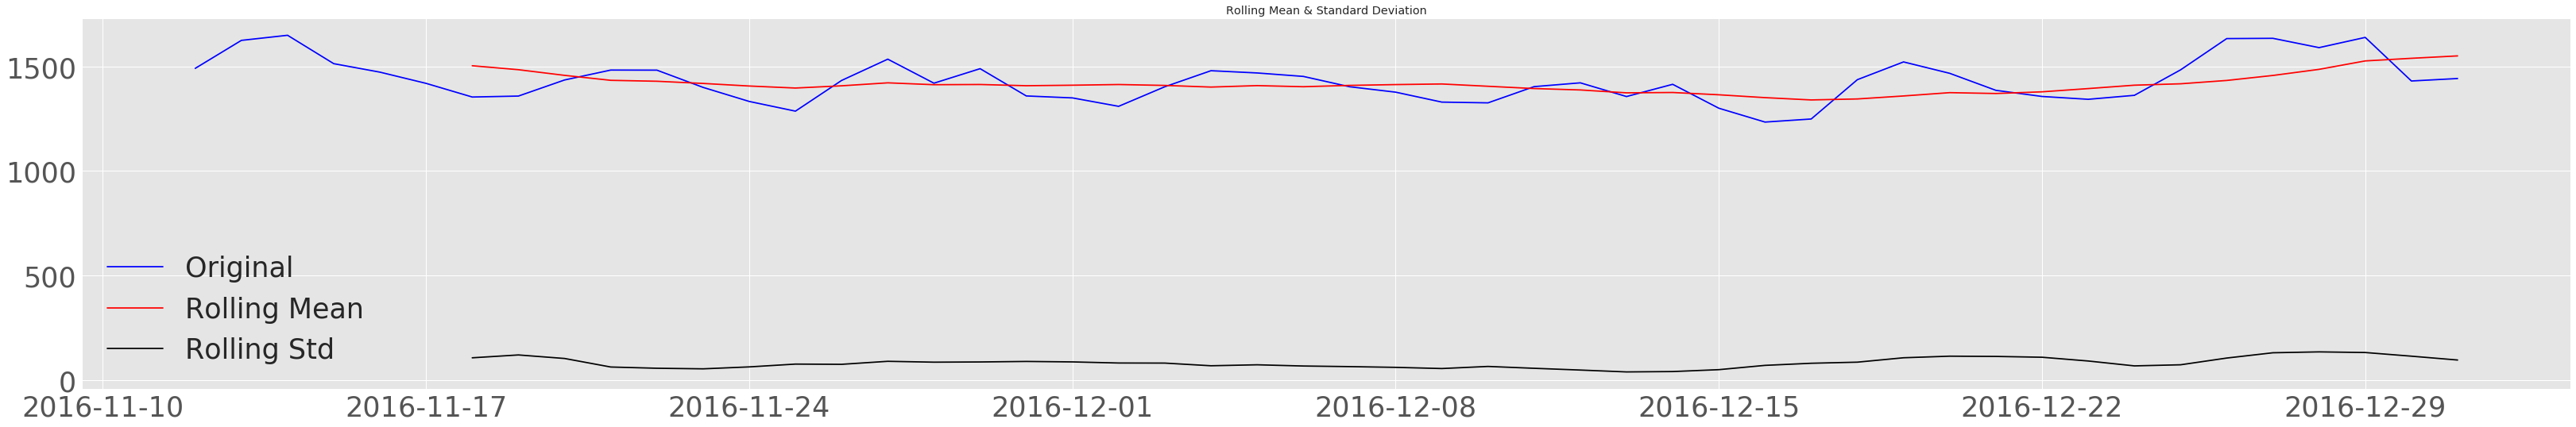

Results of Dickey-Fuller Test:
Test Statistic                 -4.261233
p-value                         0.000518
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [48]:
# Show Rolling mean, Rolling Std and Test for the stationnarity
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   

Our Time Series is stationary ! it is a good news ! We can to apply the ARIMA Model without transformations.

我们的时间序列是平稳的！这是个好消息！我们可以不用转换就可以应用ARIMA模型。

Good job ! We have a Time Series Stationary ! We can apply our ARIMA Model !!!

In [49]:
df_date_index.head()

,Visits
date,
2016-11-12,1491.626266
2016-11-13,1625.662602
2016-11-14,1650.061015
2016-11-15,1514.151238
2016-11-16,1473.522090


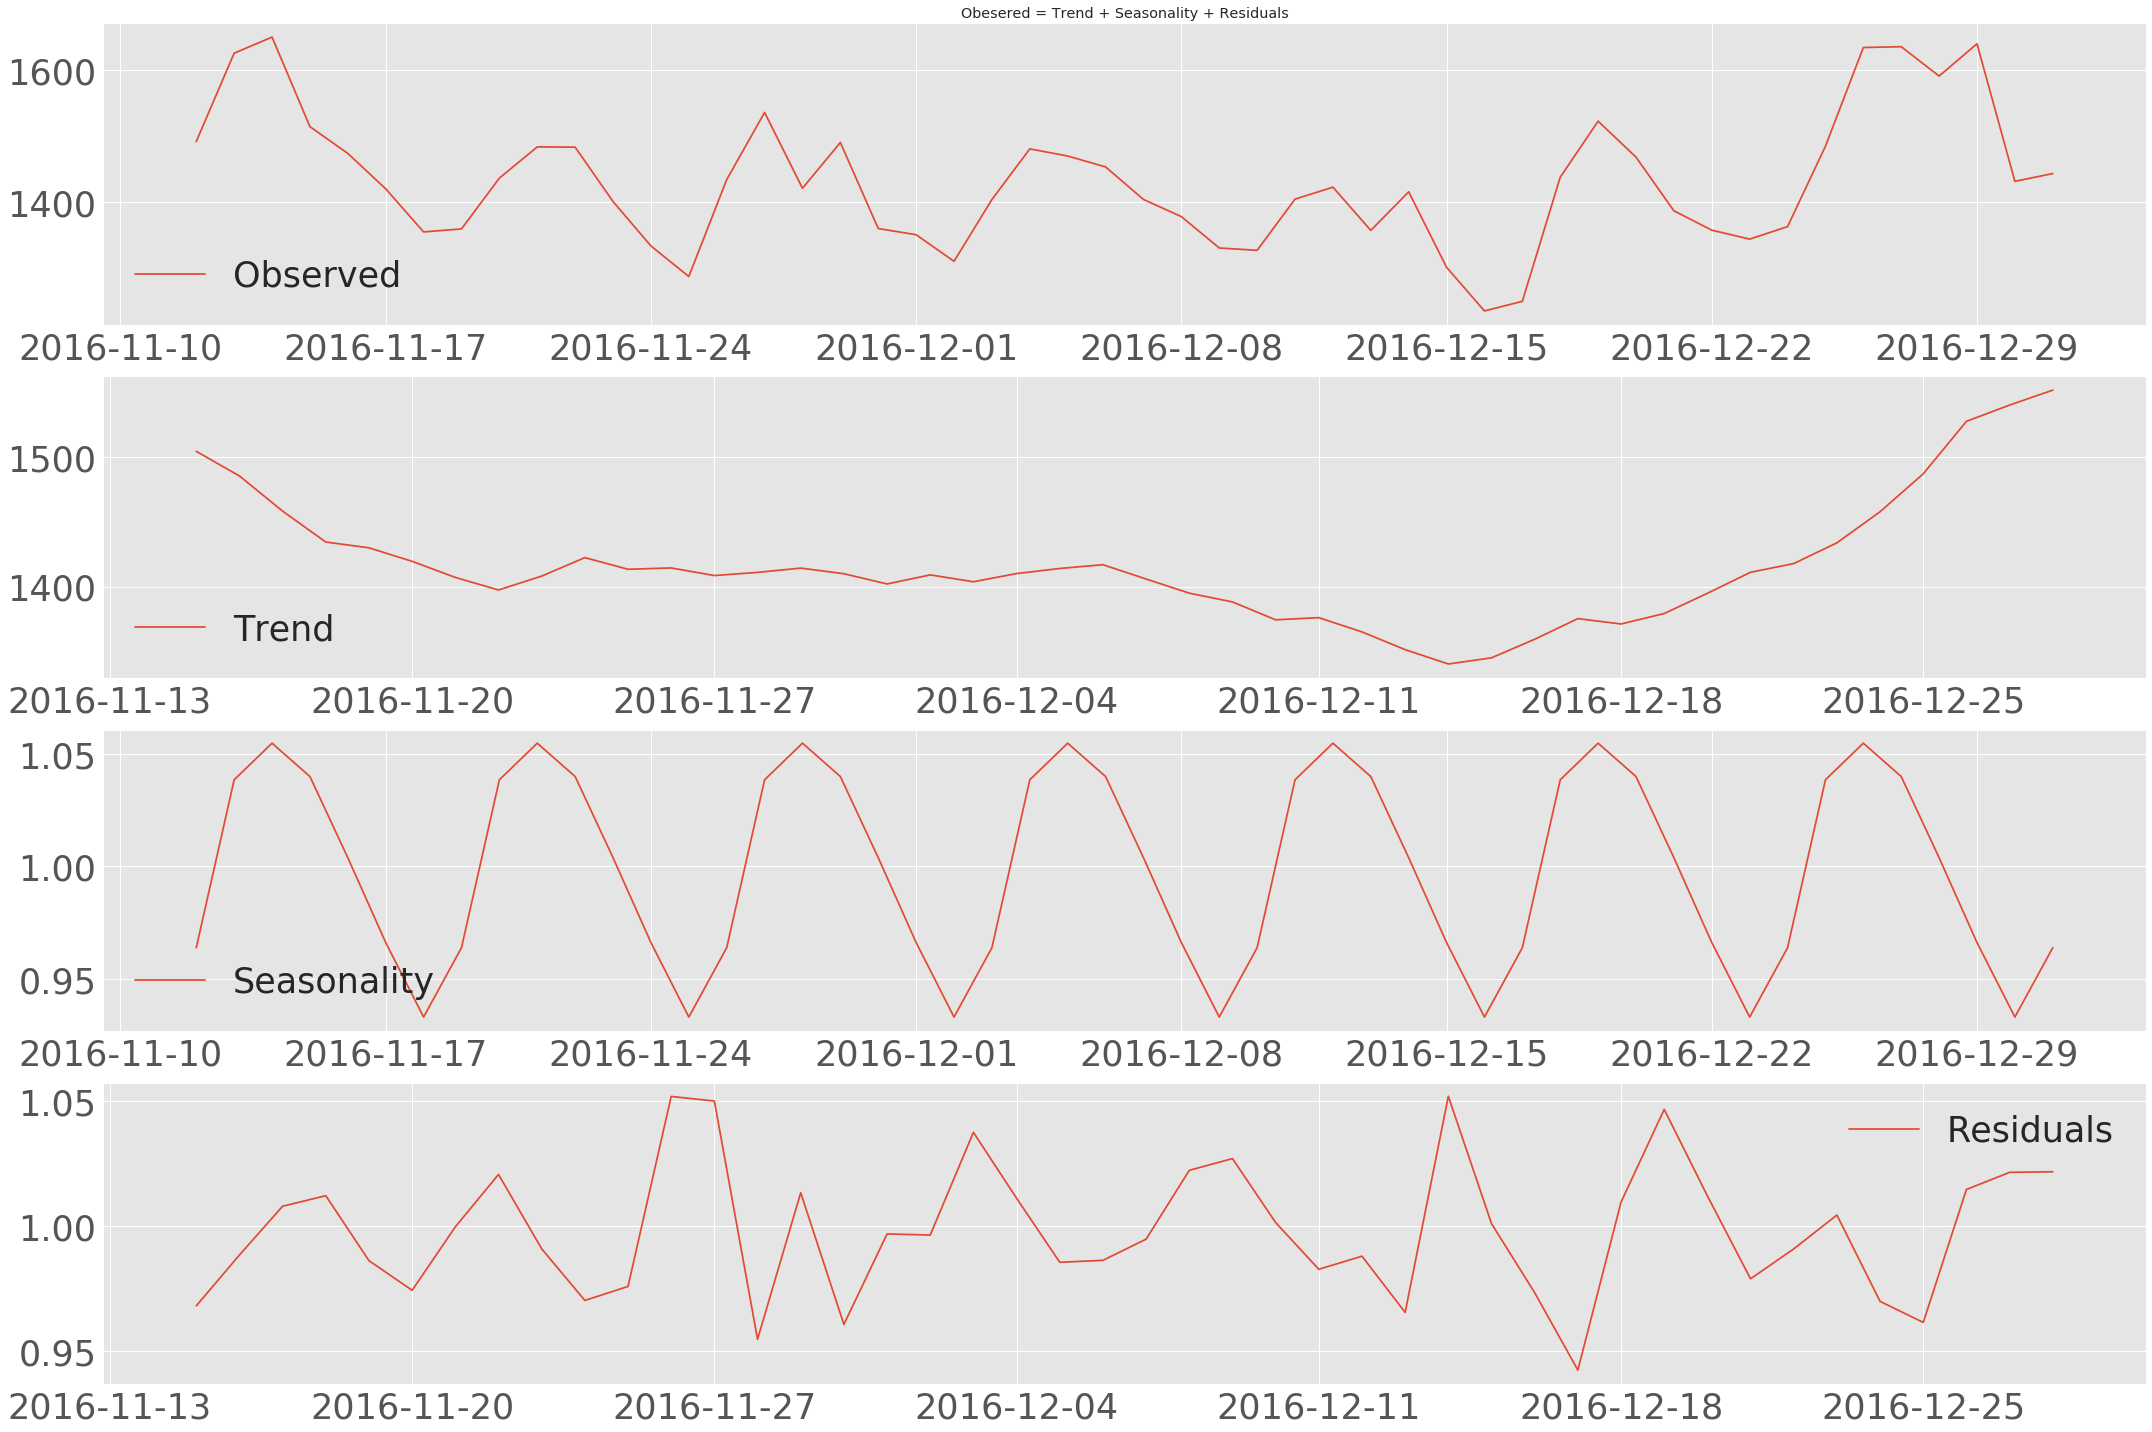

In [50]:
# Naive decomposition of our Time Series as explained above
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We expose the naive decomposition of our time series (More sophisticated methods should be preferred). They are several ways to decompose a time series but in our example we take a simple decomposition on three parts.
The additive model is Y[t] = T[t] + S[t] + e[t]
The multiplicative model is Y[t] = T[t] x S[t] x e[t]
with:

 1. T[t]: Trend 
 2. S[t]: Seasonality 
 3. e[t]: Residual

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.
In ou example we can see it is not a linear model. So it is the reason why we use a multiplicative model.

加性模型是线性的，随时间变化的量是相同的。线性趋势是一条直线。线性季节性具有相同的频率（周期宽度）和振幅（周期高度）。乘法模型是非线性的，如二次型或指数型。变化随着时间的推移而增加或减少。非线性趋势是一条曲线，非线性的季节性随时间的推移有增加或减少的频率和/或振幅。在我们的例子中，我们可以看到它不是一个线性模型。所以这就是我们使用乘法模型的原因。

In [51]:
#from statsmodels.tsa.arima_model import ARIMA

#model = ARIMA(df_date_index, order=(7, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(df_date_index, color = 'blue')
#plt.plot(results_AR.fittedvalues, color='red')
#plt.show()

In [52]:
#forecast = results_AR.forecast(steps = 30)[0]
#plt.figure(figsize=(30, 5))
#plt.plot(pd.DataFrame(np.exp(forecast)))
#plt.title('Display the predictions with the ARIMA model')
#plt.show()

In [53]:
# DataFrame to collect the predictions
#df_prediction_arima = df_date_index.copy()

#list_date = []
#for i in range(31):
#    if i >0:
#        list_date.append(last_date  + pd.to_timedelta(i, unit='D'))
    
#predictions_arima = pd.DataFrame(list_date,columns = ['Date'])
#predictions_arima['Visits'] = 0
#predictions_arima.set_index('Date',inplace=True)
#predictions_arima['Visits'] = np.exp(forecast)

#df_prediction_arima = df_prediction_arima.append(predictions_arima)
#df_prediction_arima.reset_index(drop=False,inplace=True)

In [54]:
#df_arima = df_prediction_arima[['Visits','index']]
#df_train = df_arima[df_arima['index'] <= last_date]
#df_pred = df_arima[df_prediction_arima['index'] >= last_date]
#plt.style.use('ggplot')
#plt.figure(figsize=(30, 5))
#plt.plot(df_train.index,df_train.Visits)
#plt.plot(df_pred.index,df_pred.Visits,color='b')
#plt.title('Training time series in red, Prediction on 30 days in blue -- ARIMA Model')
#plt.show()

IN PROGRESS....

#  <h1><center>VI. Prophet

Prophet is a forecasting tool availaible in python and R. This tool was created by Facebook. More information on the library here: https://research.fb.com/prophet-forecasting-at-scale/

Compared to the two methods this one will be faster. We can forecast a time series with few lines. In our case we will do a forecast and a display the trend of activity on the period and for a week.


从官网的介绍来看，`Facebook` 所提供的 `prophet` 算法不仅可以处理时间序列存在一些异常值的情况，也可以处理部分缺失值的情形，还能够几乎全自动地预测时间序列未来的走势。从论文上的描述来看，这个 `prophet` 算法是基于时间序列分解和机器学习的拟合来做的，其中在拟合模型的时候使用了 `pyStan` 这个开源工具，因此能够在较快的时间内得到需要预测的结果。除此之外，为了方便统计学家，机器学习从业者等人群的使用，`prophet` 同时提供了 `R` 语言和 `Python` 语言的接口。

参考链接：

* https://zhuanlan.zhihu.com/p/52330017

* https://blog.csdn.net/anshuai_aw1/article/details/83412058

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


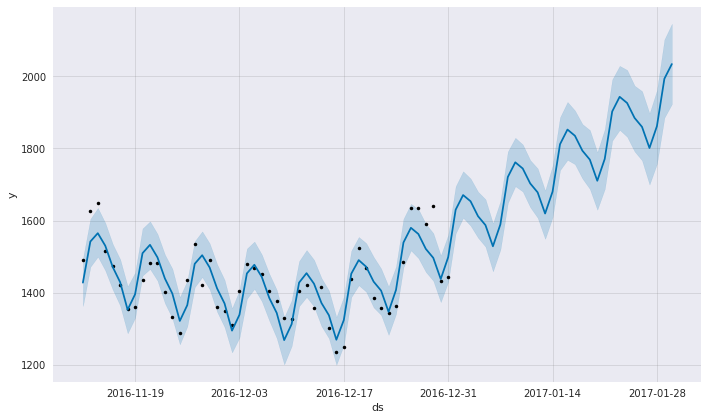

In [55]:
from fbprophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)    # 使用 Prophet 进行预测，只要保证有 ds (时间序列的时间戳) 和 y (时间序列的取值)即可开始。
future = m.make_future_dataframe(periods=30,freq='D') # 可用于构建待预测日期数据框，periods = 30 代表除历史数据的日期外再往后推 30 天
forecast = m.predict(future)
fig = m.plot(forecast)

上述图中：

* 黑色表示原始的时间序列离散点。

* 深蓝色的线表示使用时间序列来拟合所得到的取值。

* 而浅蓝色的线表示时间序列的一个置信区间，也就是所谓的合理的上界和下界。

In [57]:
# m.make_future_dataframe(periods=10)   # 可用于构建待预测日期数据框，periods = 10 代表除历史数据的日期外再往后推 10 天

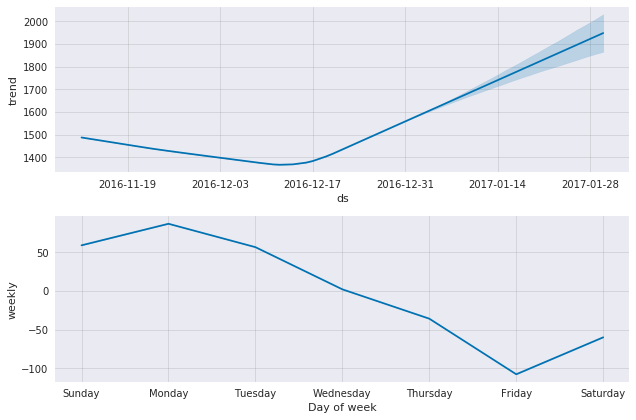

In [160]:
m.plot_components(forecast);

#  <h1><center>VI. Keras Starter

In this part we will use Keras without optimisation to forecast. It is just a very simple code to begin with Keras and a Time Series. For our example we will try just with one layer and 8 Neurons.

在本部分中，我们将使用未经优化的Keras进行预测。从Keras和时间序列开始，这只是一个非常简单的代码。在我们的例子中，我们将尝试只使用一层和8个神经元。

In [61]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))

40 10


In [ ]:
look_back = 1

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

In [ ]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_dl)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(np.array(df_dl.Visits))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Predicition with Keras')
plt.show()

 # <h1><center>VII. Comparison & Conclusion

In Progress...